# Waifu face generation

## Dataset

First download the data from a GoogleDrive folder. (Only Need to do it once)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/anime_faces

/content/drive/MyDrive/anime_faces


In [3]:
!ls

AnimeFacesVAE.ipynb  archive.zip  data	download_data.py


Only need to download the data once

In [ ]:
# %run download_data.py

In [1]:
#@title Imports
from __future__ import print_function
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torchvision.transforms as transforms
import numpy as np
import os

seed = 0
torch.manual_seed(seed)
print(f'Torch random seed: {seed}.')

Torch random seed: 0.


In [2]:
#@title Model and training parameters

training_path = "./data/train_1/"

batch_size = 128
image_size = 64
nb_channels = 3

latent_dim = 50
n_features = 64

epochs = 25
learning_rate = 5e-5

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# TODO : add training parameters (like latent space dim)

cuda


In [3]:
#@title Dataset class and transforms
training_transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


class ImageSet(Dataset):
    def __init__(self, path, transform, preload=False):
        self.path = path
        self.files = os.listdir(self.path)
        self.transform = transform
        self.preload = preload
        if self.preload:
          self.files = [
              self.transform(
                  Image.open(os.path.join(self.path, file))
              ) for file in self.files]

    def __getitem__(self, index):
        if self.preload:
          return self.files[index]
        else:
          return self.transform(
              Image.open(os.path.join(self.path, self.files[index]))
          )
    
    def __len__(self):
        return len(self.files)

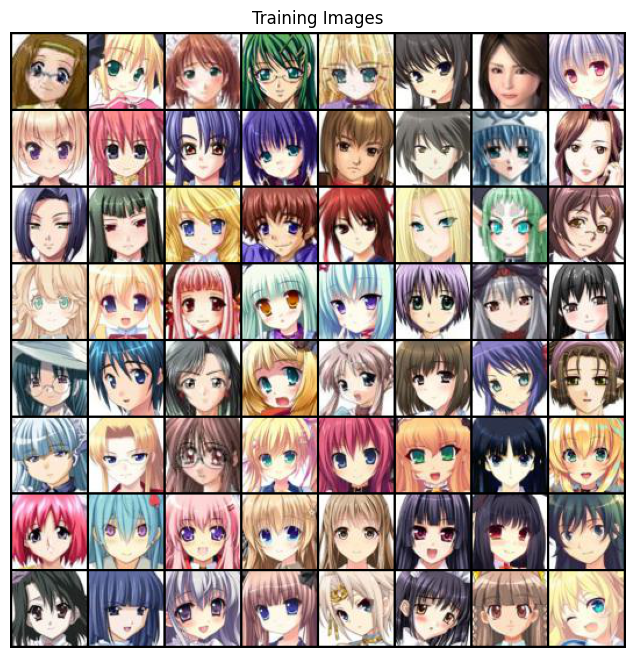

In [4]:
#@title Datasets making
training_set = ImageSet(
    path=training_path,
    transform=training_transform,
    preload=True,
)


training_loader = DataLoader(
    training_set,
    batch_size=batch_size,
    shuffle=True
)

# Plot some training images
batch = next(iter(training_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch.to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# VAE MODEL -- BASELINE

## encoder

In [62]:
# class Encoder(nn.Module):
#     def __init__(self, nb_channels, n_features, latent_dim):
#         super(Encoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(nb_channels, 16, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(16, 8, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(8, 4, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         return z

## decoder

In [63]:
# class Decoder(nn.Module):
#     def __init__(self, nb_channels, latent_dim, n_features):
#         super(Decoder, self).__init__()
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(16, nb_channels, kernel_size=3, stride=2, padding=1),
#             nn.Sigmoid(),
#         )
#     def forward(self, z):
#         x = self.decoder(z)
#         return x


## VAE

In [64]:
# class VAE(nn.Module):
#     def __init__(self, nb_channels, n_features, latent_dim):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(nb_channels, n_features, latent_dim)
#         self.decoder = Decoder(nb_channels, latent_dim, n_features)

#     def encode(self, x):
#         return self.encoder(x)

#     def decode(self, z):
#         return self.decoder(z)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         z_mean, z_log_var = torch.chunk(self.encoder(x), 2, dim=1)
#         z = self.reparameterize(z_mean, z_log_var)
#         x_hat = self.decoder(z)
#         return x_hat, z_mean, z_log_var

# VAE

In [70]:
class VAE(nn.Module):
    def __init__(self, nb_channels, n_features, latent_dim):
        super(VAE, self).__init__()
        self.nb_channels = nb_channels
        self.n_features = n_features
        self.latent_dim = latent_dim
        
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=nb_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Define mean and variance layers for latent variable
        self.fc_mu = nn.Linear(in_features=256 * (n_features // 8) ** 2, out_features=latent_dim)
        self.fc_var = nn.Linear(in_features=256 * (n_features // 8) ** 2, out_features=latent_dim)
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=256 * (n_features // 8) ** 2),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(256, n_features // 8, n_features // 8)),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=nb_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        return x_hat, mu, log_var

In [71]:
# Create an instance of the VAE model
model = VAE(nb_channels, n_features, latent_dim).to(device)



VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=50, bias=True)
  (fc_var): Linear(in_features=16384, out_features=50, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=16384, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(256, 8, 8))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 

In [92]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [93]:
# Train the model on your dataset
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, x in enumerate(training_loader):
        # Move the input data to the same device as the model
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, log_var = model(x)
        loss = vae_loss(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, loss={total_loss / len(training_loader.dataset):.4f}")


Epoch 1, loss=-128603.5957
Epoch 2, loss=-128851.5973
Epoch 3, loss=-129075.4547
Epoch 4, loss=-129318.0684
Epoch 5, loss=-129559.2476
Epoch 6, loss=-129830.4376
Epoch 7, loss=-130104.3878
Epoch 8, loss=-130341.1145
Epoch 9, loss=-130620.9094
Epoch 10, loss=-130859.2879
Epoch 11, loss=-131109.6514
Epoch 12, loss=-131364.2487
Epoch 13, loss=-131590.8493
Epoch 14, loss=-131821.5028
Epoch 15, loss=-132044.6988
Epoch 16, loss=-132275.2952
Epoch 17, loss=-132488.5103
Epoch 18, loss=-132669.1031
Epoch 19, loss=-132889.9392
Epoch 20, loss=-133070.4672
Epoch 21, loss=-133241.5697
Epoch 22, loss=-133449.1311
Epoch 23, loss=-133607.7522
Epoch 24, loss=-133807.4406
Epoch 25, loss=-133969.1832


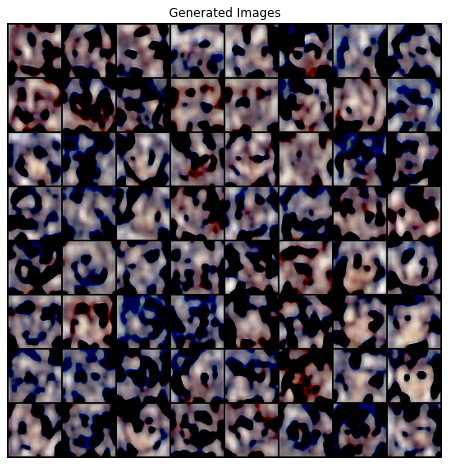

In [97]:
# generate new images
with torch.no_grad():
  random_noise = torch.randn(64, latent_dim, device=device)
  batch = model.decoder(random_noise)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=True).cpu(), (1,2,0)))